In [18]:
import pymzml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob 

In [145]:
def get_unique_mzs(scans):
    
    mzs = []
    for scan in scans:
        mzs = np.unique(list(mzs) + list(scan[:, 0]))
    
    return mzs


def get_intensities_from_unique_mzs(mzs, scans):
    
    array = np.zeros(len(mzs), dtype=np.float32)
    for scan in scans:
        array[np.searchsorted(mzs, scan[:,0])] += scan[:, 1]
        
    return array


def get_bpi_tics(mzml, intensity_threshold=10):
    
    times, bpis, tics = [], [], []

    time = 0
    
    run = pymzml.run.Reader(mzml)
    
    for scan in run:
        if (scan.ms_level == 1) and (scan.id_dict["function"] == 1):

            time_tmp = scan.scan_time_in_minutes()
            if time != time_tmp: 
                if time != 0:

                    mzs = get_unique_mzs(scans)
                    intensities = get_intensities_from_unique_mzs(mzs, scans)
                    
                    if len(intensities) == 0:
                        bpi = 0
                        tic = 0
                    else:
                        bpi = np.max(intensities)
                        tic = np.sum(intensities)

                    bpis.append(bpi)
                    tics.append(tic)

                scans = []
                time = time_tmp
                times.append(time)

            else:
                spectrum = scan.peaks("raw").astype(np.float32)
                spectrum = spectrum[spectrum[:, 1] > intensity_threshold]
                scans.append(spectrum)

    # Collect info from last time            
    mzs = get_unique_mzs(scans)
    intensities = get_intensities_from_unique_mzs(mzs, scans)
    bpi = np.max(intensities)
    tic = np.sum(intensities)
    bpis.append(bpi)
    tics.append(tic)
    
    
    return times, bpis, tics 

In [149]:
fs = sorted(glob.glob("../Lib06/*pH6/hdx_limit-pipeline/resources/2_mzml_gz/*_0s_*"))
fs

['../Lib06/20220302_pH6/hdx_limit-pipeline/resources/2_mzml_gz/20220302_Lib06_pH6_0s_01.mzML.gz',
 '../Lib06/20220302_pH6/hdx_limit-pipeline/resources/2_mzml_gz/20220302_Lib06_pH6_0s_02.mzML.gz',
 '../Lib06/20220302_pH6/hdx_limit-pipeline/resources/2_mzml_gz/20220302_Lib06_pH6_0s_03.mzML.gz',
 '../Lib06/20220302_pH6/hdx_limit-pipeline/resources/2_mzml_gz/20220304_Lib06_pH9_0s_01.mzML.gz',
 '../Lib06/20220302_pH6/hdx_limit-pipeline/resources/2_mzml_gz/20220304_Lib06_pH9_0s_02.mzML.gz',
 '../Lib06/20220302_pH6/hdx_limit-pipeline/resources/2_mzml_gz/20220304_Lib06_pH9_0s_03.mzML.gz']

In [ ]:
times, bpis, tics = [], [], []

for f in fs:
    
    print(f"Processing {f.split('/')[-1]}")
    
    t, bpi, tic = get_bpi_tics(f)
    
    times.append(t)
    bpis.append(bpi)
    tics.append(tic)

Processing 20220302_Lib06_pH6_0s_01.mzML.gz
Processing 20220302_Lib06_pH6_0s_02.mzML.gz


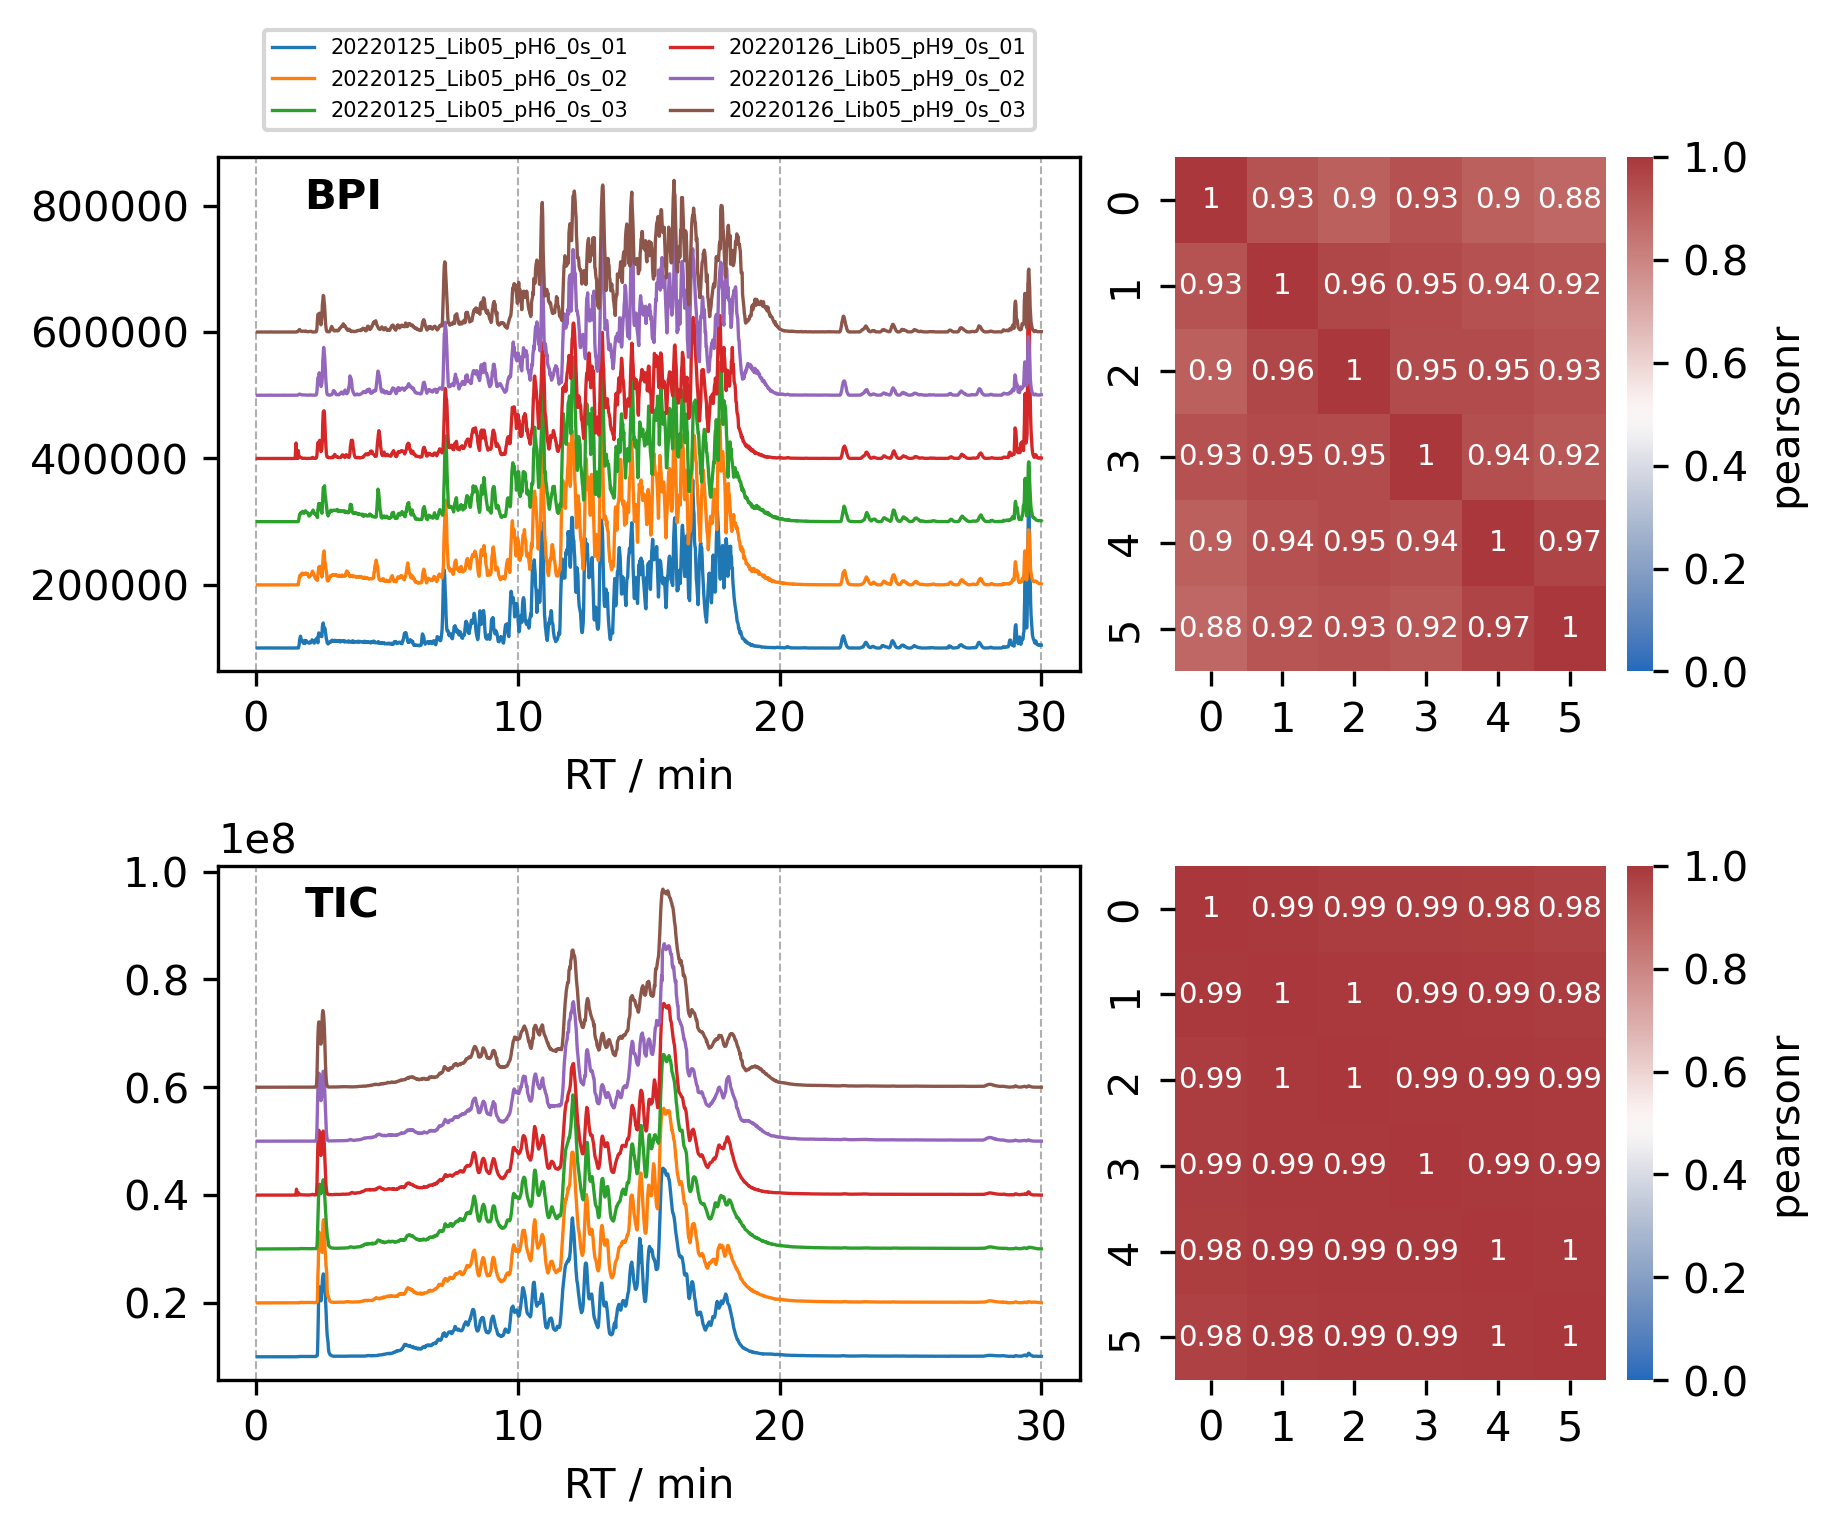

In [148]:
bpi_offset = 1e5
tic_offset = 1e7


fig, ax = plt.subplots(2,2, figsize=(6,5),  width_ratios=[2, 1], dpi=300, constrained_layout=True)

for i, f in enumerate(fs):
    
    name = f.split("/")[-1].replace(".mzML.gz", "")
    
    ax[0][0].plot(times[i], np.array(bpis[i])+(i+1)*bpi_offset, lw=0.8, label=name)
    ax[1][0].plot(times[i], np.array(tics[i])+(i+1)*tic_offset, lw=0.8, label=name)

sns.heatmap(np.corrcoef(np.array(bpis)), ax=ax[0][1], vmin=0, vmax=1, 
            cmap="vlag", cbar_kws={"label":"pearsonr"}, annot=True, annot_kws={"size": 7})
sns.heatmap(np.corrcoef(np.array(tics)), ax=ax[1][1], vmin=0, vmax=1, 
            cbar_kws={"label":"pearsonr"}, cmap="vlag", annot=True, annot_kws={"size": 7})

ax[0][0].legend(ncol=2, fontsize=5, bbox_to_anchor=[0.5, 1.15], 
           loc='center') #loc='upper center'

ax[0][0].set_xlabel("RT / min")
ax[1][0].set_xlabel("RT / min")

ax[0][0].grid(visible=True, lw=0.5, ls="--", axis='x', which='both')
ax[1][0].grid(visible=True, lw=0.5, ls="--", axis='x', which='both')

ax[0][0].text(0.1, 0.9, "BPI", weight="bold", transform=ax[0][0].transAxes)
ax[1][0].text(0.1, 0.9, "TIC", weight="bold", transform=ax[1][0].transAxes)

plt.show()